This notebook to try out a path how to identify the genotype of a patient based on the sequence of the OPN1 gene.


In [1]:
import sys
from pathlib import Path

# Add the project root directory to Python path
project_root = str(Path.cwd().parent)  # Assuming notebook is in notebooks/ directory
if project_root not in sys.path:
    sys.path.append(project_root)

# Now we can import from opsinth
from opsinth.analysis_genes import *
from opsinth.utils import *

In [2]:
ref = "../tests/out/crispr/opsinth.denovo.polished.fasta"
seq_opn1mw = "../data/GRCh38.OPN1MW.cDNA.fa"
seq_opn1lw = "../data/GRCh38.OPN1LW.cDNA.fa"

1) Find the number of OPSIN copies. Align whole cDNA (spliced)

In [3]:
alignments = align_sequences(ref, seq_opn1mw, preset="splice:hq")
nice_alignments = format_alignment_results(alignments)
print(nice_alignments)


Alignment Results:
-----------------
Reference: ref_denovo_polished
Query: OPN1MW-201
Reference Position: 76425-89673
Query Position: 0-1095
Mapping Quality: 60
Sequence Identity: 98.90%
CIGAR: 112=4939N1=1I15=1I97=1I172=1I8=1968N169=1460N58=1X1=1I66=2I22=1X14=1533N146=1I27=1I1=1X63=2262N111=
Strand: +
-----------------
Reference: ref_denovo_polished
Query: OPN1MW-201
Reference Position: 113250-126476
Query Position: 0-1095
Mapping Quality: 0
Sequence Identity: 97.99%
CIGAR: 22=1I7=2X80=4929N17=1I1=1X70=1X24=1I103=1X1=1I1X18=1X3=2I32=2I16=1972N14=1I154=1454N31=1I26=1I2=1X1=2I101=1533N104=1X135=2256N111=
Strand: +
-----------------
Reference: ref_denovo_polished
Query: OPN1MW-201
Reference Position: 39550-52789
Query Position: 0-1095
Mapping Quality: 0
Sequence Identity: 97.72%
CIGAR: 94=1X17=4935N13=1I226=1X1=2I44=1I8=1972N111=1X10=1X46=1452N38=1X25=1I52=1D49=1526N75=1X2=1X1=1X2=1X1=1X4=1X13=1X3=1X28=1D6=1X3=1X33=1X27=1I30=2264N3=1I107=
Strand: +
-----------------
Reference: ref_denovo

2) Sort alignments by start,
(2 Optional) Retain only alignments with query length > 500kB

In [4]:
alignments_filtered = [a for a in alignments if a['query_end'] - a['query_start'] > 500]
print("Kept", len(alignments_filtered), "alignments of", len(alignments), "after filtering")

# Sort alignments by reference start position
alignments_filtered.sort(key=lambda x: x['ref_start'])

# Assign sequential IDs
for i, alignment in enumerate(alignments_filtered):
    alignment['id'] = f"opn1_locus_{i + 1:02d}"

print("\nSorted alignments with IDs:")
for aln in alignments_filtered:
    print(f"ID: {aln['id']}, Position: {aln['ref_start']}-{aln['ref_end']}")



Kept 4 alignments of 4 after filtering

Sorted alignments with IDs:
ID: opn1_locus_01, Position: 744-15235
ID: opn1_locus_02, Position: 39550-52789
ID: opn1_locus_03, Position: 76425-89673
ID: opn1_locus_04, Position: 113250-126476


3) Identify the Amino Acids responsible for decision of MW or LW:
    
    
|      |    277 AA |  309 AA | 285 AA 
|------|-------|------|------|
| OPN1MW | F | F |  A |
| OPN1LW | Y | Y |  T |



In [5]:
a_opn1 = align_sequences("../data/GRCh38.OPN1MW.cDNA.fa", "../data/GRCh38.OPN1LW.cDNA.fa", preset="asm5")
nice_a_opn1 = format_alignment_results(a_opn1)
print(nice_a_opn1)

a_opn1

Alignment Results:
-----------------
Reference: OPN1MW-201
Query: OPN1LW-201
Reference Position: 0-1095
Query Position: 0-1095
Mapping Quality: 60
Sequence Identity: 98.17%
CIGAR: 193=1X105=1X30=1X15=1X341=1X7=3X6=1X113=1X2=1X1=1X2=1X1=1X4=1X13=1X3=1X34=1X3=1X33=1X169=
Strand: +
-----------------


[{'reference_name': 'OPN1MW-201',
  'query_name': 'OPN1LW-201',
  'ref_start': 0,
  'ref_end': 1095,
  'query_start': 0,
  'query_end': 1095,
  'mapping_quality': 60,
  'cigar': '193=1X105=1X30=1X15=1X341=1X7=3X6=1X113=1X2=1X1=1X2=1X1=1X4=1X13=1X3=1X34=1X3=1X33=1X169=',
  'strand': '+',
  'sequence_identity': 0.9817351598173516}]

what is wrong? Lets check the alignment in blast format

In [6]:
opn1mw_seq = read_fasta_seq("../data/GRCh38.OPN1MW.cDNA.fa")
opn1lw_seq = read_fasta_seq("../data/GRCh38.OPN1LW.cDNA.fa")

print(get_alignment_sequence(a_opn1[0], opn1mw_seq, opn1lw_seq))


ref         0: ATGGCCCAGCAGTGGAGCCTCCAAAGGCTCGCAGGCCGCCATCCGCAGGACAGCTATGAG :60
               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query       0: ATGGCCCAGCAGTGGAGCCTCCAAAGGCTCGCAGGCCGCCATCCGCAGGACAGCTATGAG :60

ref        60: GACAGCACCCAGTCCAGCATCTTCACCTACACCAACAGCAACTCCACCAGAGGCCCCTTC :120
               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query      60: GACAGCACCCAGTCCAGCATCTTCACCTACACCAACAGCAACTCCACCAGAGGCCCCTTC :120

ref       120: GAAGGCCCGAATTACCACATCGCTCCCAGATGGGTGTACCACCTCACCAGTGTCTGGATG :180
               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query     120: GAAGGCCCGAATTACCACATCGCTCCCAGATGGGTGTACCACCTCACCAGTGTCTGGATG :180

ref       180: ATCTTTGTGGTCATTGCATCCGTCTTCACAAATGGGCTTGTGCTGGCGGCCACCATGAAG :240
               ||||||||||||| ||||||||||||||||||||||||||||||||||||||||||||||
query     180: ATCTTTGTGGTCACTGCATCCGTCTTCACAAATGGGCTTGTGCTGGCGGCCACCATGAAG :240

ref       240: TTCAAGAAGCTGCGCCACCCGCTGAACTGGA

The three amino acid positions are:
- Position 277: Phenylalanine (F) in MW → Tyrosine (Y) in LW
- Position 285: Alanine (A) in MW → Threonine (T) in LW
- Position 309: Phenylalanine (F) in MW → Tyrosine (Y) in LW
To convert amino acid positions to cDNA coordinates:
1) Multiply amino acid position by 3 (since each amino acid is encoded by 3 nucleotides)
2) Subtract 3 to get the start position (since amino acid numbering starts at 1 but cDNA at 0)
Therefore:
- Position 277: cDNA 828-830 (TTC→TAC)
- Position 285: cDNA 852-854 (GCC→ACC)
- Position 309: cDNA 924-926 (TTC→TAC)

In [7]:
def read_fasta(file_path):
    with open(file_path) as f:
        header = f.readline().strip()
        sequence = ''.join(line.strip() for line in f)
    return header, sequence

mw_header, mw_seq = read_fasta("../data/GRCh38.OPN1MW.cDNA.fa")
lw_header, lw_seq = read_fasta("../data/GRCh38.OPN1LW.cDNA.fa")

variants = [(828, 830), (852, 854), (924, 926)]
for start, end in variants:
    print(f"Position {start}-{end}:")
    print(f"MW: {mw_seq[start:end+1]}")
    print(f"LW: {lw_seq[start:end+1]}")

Position 828-830:
MW: TTC
LW: TAC
Position 852-854:
MW: GCC
LW: ACC
Position 924-926:
MW: TTC
LW: TAC


Therefore the three positions are:
- cDNA 829 T->A 
- cDNA 852 G->A
- cDNA 925 T->A

Lets identify them in our alignment

In [8]:
ref_seq = read_fasta_seq("../tests/out/crispr/opsinth.denovo.polished.fasta")

#Check color variants
print("Analyzing color-determining variants:")
for aln in alignments_filtered:
    print(f"\nAnalyzing {aln['id']} ({aln['ref_start']}-{aln['ref_end']}):")
    variants = genotype_known_variants(aln, ref_seq, OPSIN_EXON5_COLOR_VARIANTS)
    
    print("Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type")
    print("-" * 70)
    
    ref_count = 0
    alt_count = 0
    
    for var in variants:
        result = var['ref_type'] if var['is_ref'] else (var['alt_type'] if var['is_alt'] else "Unknown")
        if var['is_ref']: ref_count += 1
        if var['is_alt']: alt_count += 1
        
        print(f"cDNA {var['cdna_pos']} |  {var['ref_pos']: >6} | {var['aa_change']}       | "
              f"{var['expected_ref']}/{var['expected_alt']}               | "
              f"{var['observed']}        | {result}")
    
    # Determine type
    if ref_count >= 2:
        opsin_type = "OPN1MW (Green)"
    elif alt_count >= 2:
        opsin_type = "OPN1LW (Red)"
    else:
        opsin_type = "Undetermined"
        
    print(f"\nClassification: {opsin_type}")

Analyzing color-determining variants:

Analyzing opn1_locus_01 (744-15235):
Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type
----------------------------------------------------------------------
cDNA 829 |   12709 | F>Y       | T/A               | A        | LW
cDNA 852 |   12732 | A>T       | G/A               | A        | LW
cDNA 925 |   12804 | F>Y       | T/A               | A        | LW

Classification: OPN1LW (Red)

Analyzing opn1_locus_02 (39550-52789):
Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type
----------------------------------------------------------------------
cDNA 829 |   50260 | F>Y       | T/A               | A        | LW
cDNA 852 |   50283 | A>T       | G/A               | A        | LW
cDNA 925 |   50357 | F>Y       | T/A               | A        | LW

Classification: OPN1LW (Red)

Analyzing opn1_locus_03 (76425-89673):
Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type
---------------------------------

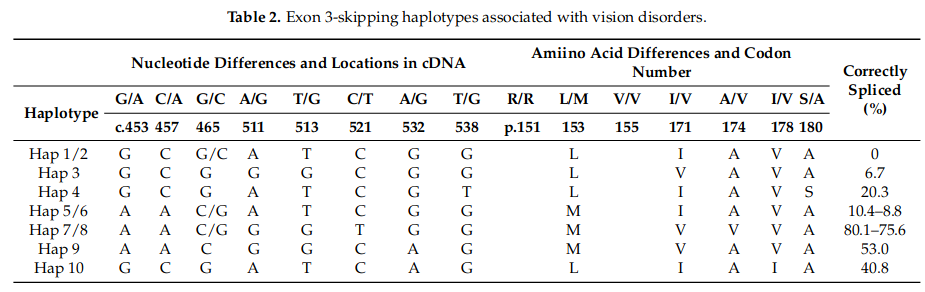

In [9]:
print("Analyzing splicing variants:")
for aln in alignments_filtered:
    print(f"\nAnalyzing {aln['id']} ({aln['ref_start']}-{aln['ref_end']}):")
    variants = genotype_known_variants(aln, ref_seq, OPSIN_EXON3_SPLICING_VARIANTS)
    
    print("Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type")
    print("-" * 70)
    
    ref_count = 0
    alt_count = 0
    
    for var in variants:
        result = var['ref_type'] if var['is_ref'] else (var['alt_type'] if var['is_alt'] else "Unknown")
        if var['is_ref']: ref_count += 1
        if var['is_alt']: alt_count += 1
        
        print(f"cDNA {var['cdna_pos']} |  {var['ref_pos']: >6} | {var['aa_change']}       | "
              f"{var['expected_ref']}/{var['expected_alt']}               | "
              f"{var['observed']}        | {result}")
    # Determine type
    # if ref_count >= 2:
    #     opsin_type = "OPN1MW (Green)"
    # elif alt_count >= 2:
    #     opsin_type = "OPN1LW (Red)"
    # else:
    #     opsin_type = "Undetermined"
        
    # print(f"\nClassification: {opsin_type}")

Analyzing splicing variants:

Analyzing opn1_locus_01 (744-15235):
Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type
----------------------------------------------------------------------
cDNA 452 |    9363 | R>R       | G/A               | A        |  
cDNA 456 |    9367 | L>M       | C/A               | A        | M
cDNA 464 |    9375 | V>V       | G/C               | C        |  
cDNA 510 |    9421 | I>V       | A/G               | G        | V
cDNA 512 |    9423 | I>V       | T/G               | G        | V
cDNA 520 |    9431 | A>V       | C/T               | T        | V
cDNA 531 |    9442 | I>V       | A/G               | A        | I
cDNA 537 |    9448 | S>A       | T/G               | T        | S

Analyzing opn1_locus_02 (39550-52789):
Pos cDNA | Pos Ref | AA Change | Expected(Ref/Alt) | Observed | Type
----------------------------------------------------------------------
cDNA 452 |   46905 | R>R       | G/A               | A        |  
cDNA 456 |   46909 